<a href="https://colab.research.google.com/github/aime-n/ic/blob/main/GCN_link_prediction_PLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KG proposto para App Reviews
----

- app_id <-> snippet (relation='contain_snippet')
- app_id <-> category (relation='is_category')
- expressao1 <-> expressao2 (relation='relation') # OBS: vem do get_relation / get_entity
- snippet <-> requirement (relation='is_requirement')
- requirement <-> entity_group (relation='contain_tag')


OBS:
- Snippet é uma sentença da review.
- Ainda não temos a categoria, entao ignorar
- entity_group é uma maneira de agrupar os requisitos. Por exemplo, vários requisitos podem ser linkados com o entity_group = 'security'. Ainda não temos essa info, podemos ignorar.



In [1]:
%load_ext autoreload
%autoreload 2

## Functions

In [2]:
# !git clone https://github.com/aime-n/ic

In [3]:
import spacy
spacy.__version__

'3.4.1'

In [4]:
# mv ./ic/* .

In [5]:
# from linkPrediction import df_metrics_per_seed

In [6]:
def df_metrics_per_seed(models, trains_flow, tests_flow):

  train_loss, train_acc = [], []
  test_loss, test_acc = [], []

  for i in range(len(seeds)):
    train_metrics = models[i].evaluate(trains_flow[i])
    test_metrics = models[i].evaluate(tests_flow[i])

    train_loss.append(train_metrics[0])
    train_acc.append(train_metrics[1])

    test_loss.append(test_metrics[0])
    test_acc.append(test_metrics[1])

  return train_loss, train_acc, test_loss, test_acc

In [7]:
def df_seeds(seeds, train_loss, train_acc, test_loss, test_acc):

  df = pd.DataFrame(
      {
      'seeds': seeds,
      'train_loss': train_loss,
      'train_acc': train_acc,
      'test_loss': test_loss,
      'test_acc': test_acc
      }
  )

  df.set_index('seeds', inplace=True)
  
  return df

In [8]:
def plot_metrics_all_seeds(df, seeds):
  plt.subplots(figsize=(8,6))

  plt.plot(df)
  plt.legend(['train_loss', 'train_acc', 'test_loss', 'test_acc'])
  plt.xlabel('Seeds')
  plt.title('Metrics')
  plt.xticks(seeds)
  plt.show()

In [9]:
def gcn_seeds_metrics_and_plots(G, seeds, test_keep_connected=True):
  hist, models, trains_flow, tests_flow = gcn_seeds(G, seeds, test_keep_connected=test_keep_connected)

  plot_history_all_seeds(hist)

  train_loss, train_acc, test_loss, test_acc = df_metrics_per_seed(models, trains_flow, tests_flow)

  df = df_seeds(seeds, train_loss, train_acc, test_loss, test_acc)
  print(df)
  print(df.mean())
  
  plot_metrics_all_seeds(df_gcc, seeds)

In [10]:
def plot_history_all_seeds(hist):
  fig, axs = plt.subplots(2,2, figsize=(12,10))

  for i in hist:
    axs[0,0].plot(i.history['binary_accuracy'])
    axs[0,0].set_title('binary_accuracy')

    axs[0,1].plot(i.history['loss'])
    axs[0,1].set_title('loss')

    axs[1,0].plot(i.history['val_binary_accuracy'])
    axs[1,0].set_title('val_binary_accuracy')

    axs[1,1].plot(i.history['val_loss'])
    axs[1,1].set_title('val_loss')

  plt.show()

In [11]:
def gcn_seeds(G, seeds, test_keep_connected=True):
  '''
  Parameters:
  ----------
  G : StellarGraph
  seeds : list
  '''

  hist = []
  models = []
  trains_flow = []
  tests_flow = []

  for seed in tqdm(seeds):
    print('-'*10, "Seed: ", seed, '-'*10)
    edge_splitter_test = EdgeSplitter(G)

    G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
        p=0.1, method="global", keep_connected=test_keep_connected, seed=seed)

    edge_splitter_train = EdgeSplitter(G_test)

    G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
        p=0.1, method="global", keep_connected=False, seed=seed)

    epochs = 50

    train_gen = FullBatchLinkGenerator(G_train, method="gcn")
    train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

    test_gen = FullBatchLinkGenerator(G_test, method="gcn")
    test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

    gcn = GCN(
        layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
    )

    x_inp, x_out = gcn.in_out_tensors()

    prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

    prediction = keras.layers.Reshape((-1,))(prediction)

    model = keras.Model(inputs=x_inp, outputs=prediction)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=keras.losses.binary_crossentropy,
        metrics=["binary_accuracy"],
    )

    history = model.fit(
        train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
    )

    hist.append(history)
    models.append(model)
    trains_flow.append(train_flow)
    tests_flow.append(test_flow)

  return hist, models, trains_flow, tests_flow

In [12]:
def edges_to_df(KG, rel='relation'):
  df_edges_linguistic = pd.DataFrame()

  source, target, relation = [], [], []
  for edge in KG.edges(data=True):
    source.append(edge[0])
    target.append(edge[1])
    relation.append(edge[2][rel])

  df_edges_linguistic['source'] = source
  df_edges_linguistic['relation'] = relation
  df_edges_linguistic['target'] = target

  return df_edges_linguistic

In [13]:
def matrix_adj(KG):
  adj_matrix = nx.adjacency_matrix(KG).todense()

  df_adj_matrix = pd.DataFrame(adj_matrix)

  df_adj_matrix['index'] = list(KG.nodes)
  df_adj_matrix.set_index('index', inplace=True)
  df_adj_matrix.columns = list(KG.nodes)

  return df_adj_matrix

In [14]:
def create_stellargraph(KG):
  df = edges_to_df(KG)
  matrix = matrix_adj(KG)

  G = sg.StellarGraph(matrix, df[['source', 'target']])
  
  return G

In [15]:
def gcn_function(SG, seed=42, epochs=50, show_metrics_untrained=False, show_metrics_trained=True, show_history=True):
  edge_splitter_test = EdgeSplitter(SG)
  G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
      p=0.1, method="global", keep_connected=False, seed=seed)
  
  edge_splitter_train = EdgeSplitter(G_test)
  G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
      p=0.1, method="global", keep_connected=False, seed=seed)
  
  train_gen = FullBatchLinkGenerator(G_train, method="gcn")
  train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

  test_gen = FullBatchLinkGenerator(G_test, method="gcn")
  test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

  gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3)
  
  x_inp, x_out = gcn.in_out_tensors()

  prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
  prediction = keras.layers.Reshape((-1,))(prediction)

  model = keras.Model(inputs=x_inp, outputs=prediction)
  model.compile(
      optimizer=keras.optimizers.Adam(lr=0.01),
      loss=keras.losses.binary_crossentropy,
      metrics=["binary_accuracy"],)

  init_train_metrics = model.evaluate(train_flow)
  init_test_metrics = model.evaluate(test_flow)

  if show_metrics_untrained == True:
    print("\nTrain Set Metrics of the initial (untrained) model:")
    for name, val in zip(model.metrics_names, init_train_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    print("\nTest Set Metrics of the initial (untrained) model:")
    for name, val in zip(model.metrics_names, init_test_metrics):
        print("\t{}: {:0.4f}".format(name, val))

  history = model.fit(
      train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
  )

  if show_history == True:
    print(sg.utils.plot_history(history))

  train_metrics = model.evaluate(train_flow)
  test_metrics = model.evaluate(test_flow)

  if show_metrics_trained == True:
    print("\nTrain Set Metrics of the trained model:")
    for name, val in zip(model.metrics_names, train_metrics):
        print("\t{}: {:0.4f}".format(name, val))
        train_acc = val


    print("\nTest Set Metrics of the trained model:")
    for name, val in zip(model.metrics_names, test_metrics):
        print("\t{}: {:0.4f}".format(name, val))
        test_acc = val

  return round(train_acc, 5), round(test_acc, 5)

In [16]:
def select_index_edges(G, indexes):
  g = G.to_networkx()
  g = nx.Graph(g)
  edges = list(g.edges)
  selected_edges = [edges[i] for i in indexes]
  # print(selected_edges)

  g_selected = nx.edge_subgraph(g, selected_edges).copy()
  nx.set_node_attributes(g_selected, dic_adj, 'adj')

  G_selected = sg.StellarGraph.from_networkx(g_selected, node_features='adj', edge_type_attr='label')

  return G_selected

# KG atual para testes preliminares

- expressao1 <-> expressao2 (relation='relation') # OBS: vem do get_relation / get_entity
- snippet <-> requirement (relation='is_requirement')

## Knowledge Graph

### Libraries and functions for KG

In [33]:
# !git clone https://github.com/HaoWeiHe/Knowledge-Graph

In [34]:
mv ./Knowledge-Graph/* .

mv: cannot stat './Knowledge-Graph/*': No such file or directory


In [35]:
import spacy
spacy.__version__

'3.4.1'

In [36]:
from knowledgeGraph import get_entity
from knowledgeGraph import get_relation

- get_entity: <br>
Noun related tags (subject/object)
- get_relation: <br>
Dependency between them (predicate) <br><br>
Ex.:


In [37]:
%aimport knowledgeGraph

Entities: ('milky way', 'spiral arms')
Relation: #


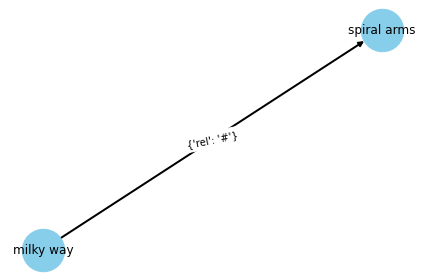

In [38]:
from knowledgeGraph import information
from knowledgeGraph import show

text = '''
# The milky way has spiral arms'''

entities = get_entity(text)
rel = get_relation(text)
print(f'Entities: {entities}')
print(f'Relation: {rel}')
show(text)

In [39]:
import pandas as pd

In [40]:
import nltk # Natural Language ToolKit
from nltk.tokenize import sent_tokenize # sentence tokenizer
nltk.download('punkt')
import networkx as nx # graph lib
from tqdm.notebook import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


- sent_tokenize: <br>
It splits the text into sentences. <br> <br>
Ex.: 

In [41]:
text = '''How happy is the blameless vestal's lot!
The world forgetting, by the world forgot.
Eternal sunshine of the spotless mind!
Each pray'r accepted, and each wish resign'd; '''

for sentence in sent_tokenize(text):
  print('-->', sentence)

--> How happy is the blameless vestal's lot!
--> The world forgetting, by the world forgot.
--> Eternal sunshine of the spotless mind!
--> Each pray'r accepted, and each wish resign'd;


### Original Data

In [42]:
ground_truth = pd.read_csv('https://raw.githubusercontent.com/aime-n/ic/main/Ground_truth.csv')
ground_truth.head()

,App id,Review id,Sentence id,Sentence content,Feature (Positive),Feature (Neutral),Feature (Negative),Feature (All Annotated)
0,com.zentertain.photoeditor,gp:AOqpTOEW40L9WXqCjzq04bqaZImgMdzlczxIF3_ibs8...,1,May be i can check,NaN,NaN,NaN,NaN
1,com.zentertain.photoeditor,gp:AOqpTOF57AQPvmnCiWYurwLY-F2-mej25ON8RAFk-Ls...,1,It make me happy,NaN,NaN,NaN,NaN
2,com.zentertain.photoeditor,gp:AOqpTOHYdmt72q4tSD8TZ8A5fZQqGivlBkIbWuHuJMZ...,1,I have a normal phone and it made 1 of my pics...,NaN,pics,NaN,pics
3,com.zentertain.photoeditor,gp:AOqpTOFYnXMShrDJPS0jpM04pFQxYOJN1LDuX3lSNm0...,1,Love it so much,NaN,NaN,NaN,NaN
4,com.zentertain.photoeditor,gp:AOqpTOF_JO496wnThQ2kcYlPct_g1GhOmQyyVvHp4VV...,1,Cant get to install,NaN,install,NaN,install


In [43]:
ground_truth['App id'].unique()

array(['com.zentertain.photoeditor', 'B004LOMB2Q', 'B004SIIBGU',
       'com.whatsapp', 'B005ZXWMUS', 'com.twitter.android', 'B0094BB4TW',
       'com.spotify.music'], dtype=object)

In [44]:
ground_truth.groupby('App id').count()

,Review id,Sentence id,Sentence content,Feature (Positive),Feature (Neutral),Feature (Negative),Feature (All Annotated)
App id,,,,,,,
B004LOMB2Q,367,367,367,69,105,9,170
B004SIIBGU,294,294,294,64,67,6,128
B005ZXWMUS,341,341,341,54,113,16,170
B0094BB4TW,327,327,327,31,100,23,145
com.spotify.music,227,227,227,24,86,20,119
com.twitter.android,183,183,183,4,71,14,86
com.whatsapp,169,169,169,13,60,14,83
com.zentertain.photoeditor,154,154,154,32,36,8,70


In [45]:
ground_truth.size

16496

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 <a list of 10 Text major ticklabel objects>)

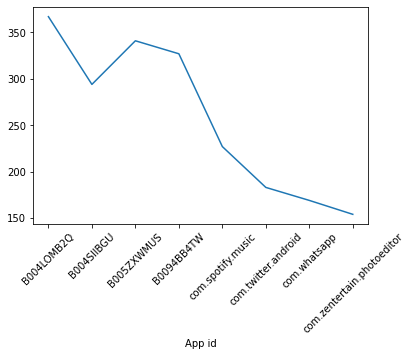

In [46]:
import matplotlib.pyplot as plt

ground_truth.groupby('App id').count()['Review id'].plot()
plt.xticks(rotation=45)

### Creation of KG

In [47]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stops = set(stopwords.words('english'))

def is_stopword(s):
  for w in s.split(' '):
    if w.lower() not in stops: return False

  return True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [48]:
def addinto_valuelist(dic, key, value):
  '''
  Adds into list of key's values.
  '''
  if key in dic:
    l = dic[key]
    if value not in l: 
      l.append(value)
      dic[key] = l
  else:
    dic[key] = [value]

In [49]:
from knowledgeGraph import get_relation
KG = nx.Graph()
# index_l = []
dic_app_id = {}

i = 0
print('Print of the first reviews:')
for index, row in tqdm(ground_truth.iterrows(),total=len(ground_truth)): 
  review = row['Sentence content']
  appid = row['App id']
  # tqdm => progress bar
  for sentence in sent_tokenize(review):
    if i < 30:
      print(f'--> {sentence}')

    nodes = get_entity(sentence) # (subject, object)
    sub, obj = nodes[0], nodes[1]

    rel = get_relation(sentence) # predicate

    # ignore less than 2 letter words
    if len(sub) > 2 and len(obj) > 2 and len(rel) > 2:
      if is_stopword(sub): continue
      if is_stopword(obj): continue
      if is_stopword(rel): continue
      # show(sentence)
      if i < 30:
        print(f'subject: {sub}\nrelation: {rel}\nobject: {obj}')
        i+=1
      # index_l.append(i)

      addinto_valuelist(dic_app_id, sub, appid)
      addinto_valuelist(dic_app_id, obj, appid)
      addinto_valuelist(dic_app_id, review, appid)

      KG.add_edge(sub, obj, relation=rel)
      KG.add_edge(review, obj, relation='contains')
      KG.add_edge(review, sub, relation='contains')

Print of the first reviews:


  0%|          | 0/2062 [00:00<?, ?it/s]

--> May be i can check
--> It make me happy
--> I have a normal phone and it made 1 of my pics look like one of a iphone 6 if u dont believe me look at my instagran account ... wings_2004
--> Love it so much
--> Cant get to install
--> Too many ads and secondly erratic interface.
--> I have already uninstalled
--> Its so happy
--> Nicest systematic for Android phones
--> Its so easy and fun
--> Main diss app tight um hmmm
--> Everything is awesome
--> I've downloaded a few different ones and this is easy to use, and the pictures come out great.
subject: pictures
relation: download
object: a few different ones
--> Plenty of options to choose from to make whatever kind of picture you would like
--> Like it but not so cool app
--> I really like the HD effect, brightness and color correction features.
--> I can basically change the whole pic   its so cool :-) lol :-)
--> I can't  believe  how easy  it is.
--> This app is very good for photos editer
--> It is just simple and Good app.
--> I

In [50]:
len(dic_app_id.keys())

552

In [51]:
print(f'Number of nodes: {len(KG.nodes)}')
print(f'Number of edges: {len(KG.edges)}')

Number of nodes: 552
Number of edges: 627


In [52]:
for i in list(KG.edges(data=True))[:10]:
  print(i)

('pictures', 'a few different ones', {'relation': 'download'})
('pictures', "I've downloaded a few different ones and this is easy to use, and the pictures come out great.", {'relation': 'contains'})
('pictures', 'cell phones', {'relation': 'hold'})
('pictures', 'pictures are great since picture taking and developing is getting to be a thing of the past, cell phones hold their pictures.', {'relation': 'contains'})
('a few different ones', "I've downloaded a few different ones and this is easy to use, and the pictures come out great.", {'relation': 'contains'})
('splash', 'focus help', {'relation': 'use'})
('splash', 'Ive used this on my previous phone.worked prrfectly but ive recntly bought samsung galaxy a5 the splash and focus functn doesnt work.plz help!!', {'relation': 'contains'})
('focus help', 'Ive used this on my previous phone.worked prrfectly but ive recntly bought samsung galaxy a5 the splash and focus functn doesnt work.plz help!!', {'relation': 'contains'})
('editing many 

In [53]:
for i in list(nx.connected_components(KG))[:10]:
  print(i)

{'cell phones', 'pictures are great since picture taking and developing is getting to be a thing of the past, cell phones hold their pictures.', 'a few different ones', 'pictures', "I've downloaded a few different ones and this is easy to use, and the pictures come out great."}
{'focus help', 'splash', 'Ive used this on my previous phone.worked prrfectly but ive recntly bought samsung galaxy a5 the splash and focus functn doesnt work.plz help!!'}
{'photo editing', 'editing many options', 'lighter and faster than other photo editors ,with many editing options best recommended app for photo editing'}
{'super i', 'super easy and i love the effects ,also super easy to install!!', 'effects'}
{'best lot it', 'editing so many photo tools', "I`ve seen so many photo editing tools but this one is the best 10x a lot it's really proffesional"}
{'frnds...every one should must install in your phone .', 'one', 'First, why do you need Access to my phone?', 'I end up having to restart my phone just so 

### Adicionando relacoes snippet <=> requirement

In [54]:
def isNaN(num):
    return num != num

for index,row in tqdm(ground_truth.iterrows(),total=len(ground_truth)):
  node1 = row['Sentence content']
  node2 = row['Feature (All Annotated)']
  appid = row['App id']
  if isNaN(node2)==False:
    for node in node2.split(';'):
      print(node)
      addinto_valuelist(dic_app_id, node, appid)
      addinto_valuelist(dic_app_id, node1, appid)

      KG.add_edge(node1,node,relation='is_requirement')

  0%|          | 0/2062 [00:00<?, ?it/s]

pics
install
ads
interface
uninstalled
pictures
options to choose from
make whatever kind of picture
HD effect
brightness correction
color correction
change the whole pic
photos editer
splash functn
focus functn
make a video editor
book covers
photo editing
photo editors
editing
effects
install
ads
filters
Covers imperfections
ads popping up
ad pops up
photo editing
photo editing
take photo
add to photo
editing
effects
photo editor
effects
editor
Photo Editing
editing Photo's
edit pics
the results I get
make AMAZING photos
rate me pls' always pops out
airbrush feature
create amazing fotos
delete previously 'edited' needless photos
gallery
delete 'just those photos'
maintaining the original photo
frames
enhanced picture qualities
frames
detail options
frame options
adverts
photo editor
popups
option to un blur the blur photos
choose a photo
black screen came up
photo
add in another photo
photo
edit
perfects flaws
perfects inperfections
FONT
change the FONT Text
affects
download the stic

In [55]:
len(dic_app_id.keys())

2526

In [56]:
print(f'Number of nodes: {len(KG.nodes)}')
print(f'Number of edges: {len(KG.edges)}')

Number of nodes: 2526
Number of edges: 2115


### adding appid attr

In [57]:
# nx.set_node_attributes(KG, dic_app_id, "app_id")

In [58]:
# KG.nodes(data=True)

### Verificando todas as conexoes da estrutura linguistica

In [59]:
for v in KG.edges(data=True):
  if v[2]['relation']!='is_requirement':
    print(v)

('pictures', 'a few different ones', {'relation': 'download'})
('pictures', 'cell phones', {'relation': 'hold'})
('a few different ones', "I've downloaded a few different ones and this is easy to use, and the pictures come out great.", {'relation': 'contains'})
('splash', 'focus help', {'relation': 'use'})
('splash', 'Ive used this on my previous phone.worked prrfectly but ive recntly bought samsung galaxy a5 the splash and focus functn doesnt work.plz help!!', {'relation': 'contains'})
('focus help', 'Ive used this on my previous phone.worked prrfectly but ive recntly bought samsung galaxy a5 the splash and focus functn doesnt work.plz help!!', {'relation': 'contains'})
('editing many options', 'photo editing', {'relation': 'recommend'})
('editing many options', 'lighter and faster than other photo editors ,with many editing options best recommended app for photo editing', {'relation': 'contains'})
('super i', 'effects', {'relation': 'easy'})
('super i', 'super easy and i love the eff

### Verificando conexoes entre o KG linguistico e KG requisitos anotados

In [60]:
for v in KG.edges(data=True):
  if v[2]['relation']!='is_requirement':
    print(v)
    for v2 in KG.neighbors(v[0]):
      print("\t\t-->",v2)
    for v2 in KG.neighbors(v[1]):
      print("\t\t-->",v2)

Streaming output truncated to the last 5000 lines.
		--> Y'all needa
		--> Y'all needa fix this app y'all bugging man.
		--> fine standards
		--> This app worked fine by my standards.
		--> Disappointed
		--> Same as a smartphone... Disappointed, need to get with increasing the quality for an app.
		--> whenever I
		--> I did love this app but now since the last two updates it keeps shutting down whenever I open up another app.
		--> more day
		--> This app is becoming more and more useless by the day.
		--> a couple exceptions
		--> app
('app', 'smart TV', {'relation': 'try'})
		--> Aviary
		--> Without Aviary this app cannot working
		--> other wireless devices
		--> This app was constantly updating, contacting me and trying to get on my other wireless devices.
		--> laptop
		--> this app allows for sharing and can be typed on your laptop as well!
		--> excellent computer
		--> i can access my notes from my other computers, organize them in notebooks and tags and add web content and 

### OBS: os requisitos extraídos pelo BERT podem ser adicionados na rede da mesma forma dos anotados manualmente...

In [61]:
# def isNaN(num):
#     return num != num

# rebert_requisitos = CSV_REBERT
# for index,row in tqdm(rebert_requisitos.iterrows(),total=len(rebert_requisitos)):
#   node1 = row['Sentence content']
#   node2 = row['Feature (bert)'] # VERIFICAR
#   if isNaN(node2)==False:
#     for node in node2.split(';'):
#       print(node)
#       KG.add_edge(node1,node,relation='is_requirement')

### KG Visualization

A closer look.<br>
Drawing only the biggest chunk of connected nodes for visualization purpose

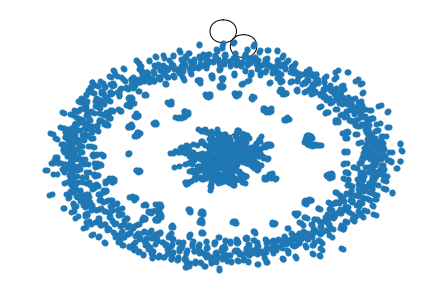

In [62]:
nx.draw(KG, node_size=25)
plt.savefig('nx_draw')

Number of nodes of the gcc: 542
Percentage of the original graph: 0.21456848772763262


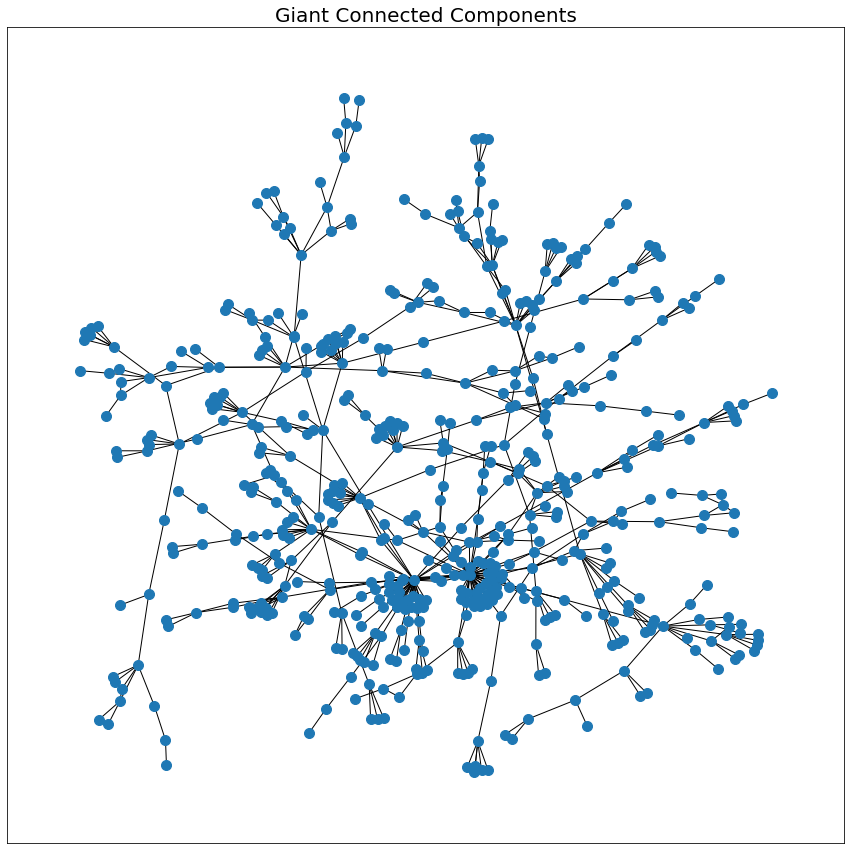

In [63]:
import matplotlib.pyplot as plt
gcc = (max(nx.connected_components(KG), key=len)) # giant connected component
subgraph_ = KG.subgraph(gcc)
print(f'Number of nodes of the gcc: {len(subgraph_.nodes)}')
print(f'Percentage of the original graph: {len(subgraph_.nodes)/len(KG.nodes)}')
options = {
    "font_size": 10,
    "node_size": 100,
}

plt.figure(figsize=(15,15)) 
nx.draw_networkx(subgraph_, **options, 
                 with_labels=False
                 )
plt.title('Giant Connected Components', fontsize=20)
plt.savefig('gcc')
plt.show()

### Creation of DataFrame of edges

In [64]:
df_edges_linguistic = edges_to_df(KG)

In [65]:
df_edges_linguistic.head()

,source,relation,target
0,pictures,download,a few different ones
1,pictures,is_requirement,I've downloaded a few different ones and this ...
2,pictures,hold,cell phones
3,pictures,is_requirement,pictures are great since picture taking and de...
4,pictures,is_requirement,Well for one thing your app doesn't look anyth...


In [66]:
df_edges_linguistic.relation.unique()

array(['download', 'is_requirement', 'hold', 'contains', 'use',
       'recommend', 'easy', 'see', 'need', 'install', 'end', 'work',
       'update', 'allow', 'access', 'change', 'lay', 'find', 'improve',
       'make', 'seem', 'like', 'try', 'sit', 'decide', 'lock', 'fix',
       'love', 'become', 'nice', 'wondering', 'killer', 'help', 'handy',
       'stay', 'close', 'worth', 'note', 'upgrade', 'consider', 'show',
       'understand', 'come', 'write', 'web', 'heavy', 'stuff', 'get',
       'app', 'keep', 'unreadable', 'wish', 'appreciate', 'attempt',
       'check', 'ignore', 'hog', 'run', 'buy', 'time', 'put', 'connect',
       'sell', 'kill', 'resolve', 'appear', 'aapp', 'turn', 'lag',
       'profile', 'send', 'give', 'ask', 'save', 'prefer', 'hang',
       'happy', 'play', 'enjoy', 'leave', 'watch', 'area', 'think',
       'count', 'tell', 'frustrating', 'say', 'load', 'take', 'exist',
       'isss', 'tab', 'famous', 'deactivate', 'look', 'want', 'useless',
       'tend', 'suppor

In [67]:
df_edges_linguistic.source.unique()

array(['pictures', 'a few different ones', 'splash', ...,
       'I guess the only free part is the uninstall button.',
       'Even advertisement is not to frequent while enjoying my awesome Playlist.',
       'This app really awesome i can listen whatever music i want!'],
      dtype=object)

In [68]:
df_edges_linguistic.target.unique()

array(['a few different ones',
       "I've downloaded a few different ones and this is easy to use, and the pictures come out great.",
       'cell phones', ..., 'Playlist', 'advertisement',
       'listen whatever music i want'], dtype=object)

In [69]:
print(f'Length of df edges linguistic: {len(df_edges_linguistic)}')

Length of df edges linguistic: 2115


### Matrix adjacency

In [70]:
# from linkPrediction import matrix_adj
import networkx as nx

df_adj_matrix = matrix_adj(KG)

df_adj_matrix.head()

,pictures,a few different ones,"I've downloaded a few different ones and this is easy to use, and the pictures come out great.",splash,focus help,Ive used this on my previous phone.worked prrfectly but ive recntly bought samsung galaxy a5 the splash and focus functn doesnt work.plz help!!,editing many options,photo editing,"lighter and faster than other photo editors ,with many editing options best recommended app for photo editing",super i,...,download the songs,random music pops up,I guess the only free part is the uninstall button.,uninstall button,Even advertisement is not to frequent while enjoying my awesome Playlist.,Playlist,advertisement,This app really awesome i can listen whatever music i want!,listen whatever music i want,Works great for working out and premium is beyond worth it!!!!
index,,,,,,,,,,,,,,,,,,,,,
pictures,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a few different ones,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"I've downloaded a few different ones and this is easy to use, and the pictures come out great.",1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
splash,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
focus help,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
print(f'Matrix shape: {df_adj_matrix.shape}') # len(nodes) x len(nodes)

Matrix shape: (2526, 2526)


In [72]:
print(f'Is its length the same as the KG.nodes? {len(KG.nodes) == len(df_adj_matrix)}')

Is its length the same as the KG.nodes? True


In [73]:
dic_adj = {}
for index, row in tqdm(df_adj_matrix.iterrows(),total=len(df_adj_matrix)): 
  dic_adj[index] = row.to_list()

  0%|          | 0/2526 [00:00<?, ?it/s]

In [74]:
KG.edges.data()

EdgeDataView([('pictures', 'a few different ones', {'relation': 'download'}), ('pictures', "I've downloaded a few different ones and this is easy to use, and the pictures come out great.", {'relation': 'is_requirement'}), ('pictures', 'cell phones', {'relation': 'hold'}), ('pictures', 'pictures are great since picture taking and developing is getting to be a thing of the past, cell phones hold their pictures.', {'relation': 'is_requirement'}), ('pictures', "Well for one thing your app doesn't look anything like the pictures above and for another I got to edit one photo and then the app wouldn't open and kept force closing I hate it so I removed imedently", {'relation': 'is_requirement'}), ('pictures', 'I save everything on Evernote, I mean pictures, magazine clips, recipes, thoughts, you name it.', {'relation': 'is_requirement'}), ('pictures', "After the first 10 or so posts the rest just load as blue text without pictures and it doesn't change after refresh.", {'relation': 'is_require

In [75]:
KG.edges(data=True)

EdgeDataView([('pictures', 'a few different ones', {'relation': 'download'}), ('pictures', "I've downloaded a few different ones and this is easy to use, and the pictures come out great.", {'relation': 'is_requirement'}), ('pictures', 'cell phones', {'relation': 'hold'}), ('pictures', 'pictures are great since picture taking and developing is getting to be a thing of the past, cell phones hold their pictures.', {'relation': 'is_requirement'}), ('pictures', "Well for one thing your app doesn't look anything like the pictures above and for another I got to edit one photo and then the app wouldn't open and kept force closing I hate it so I removed imedently", {'relation': 'is_requirement'}), ('pictures', 'I save everything on Evernote, I mean pictures, magazine clips, recipes, thoughts, you name it.', {'relation': 'is_requirement'}), ('pictures', "After the first 10 or so posts the rest just load as blue text without pictures and it doesn't change after refresh.", {'relation': 'is_require

In [76]:
print(nx.info(KG))

Graph with 2526 nodes and 2115 edges


# GCN implementation with matrix adjacency as feature

### Importing libraries for GCN

In [77]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 30.4 MB/s 
     |████████████████████████████████| 500 kB 72.9 MB/s 
     |████████████████████████████████| 120 kB 74.5 MB/s 
     |████████████████████████████████| 1.6 MB 64.5 MB/s 
     |████████████████████████████████| 82 kB 517 kB/s 
     |████████████████████████████████| 41 kB 681 kB/s 


In [78]:
import stellargraph as sg

In [79]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

### Building StellarGraph

In [80]:
G_adj = sg.StellarGraph(KG, node_features=df_adj_matrix, edge_type_name='relation')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Constructing a StellarGraph directly from a NetworkX graph has been replaced by the `StellarGraph.from_networkx` function
  """Entry point for launching an IPython kernel.


In [81]:
print(G_adj.info())

StellarGraph: Undirected multigraph
 Nodes: 2526, Edges: 2115

 Node types:
  default: [2526]
    Features: float32 vector, length 2526
    Edge types: default-aapp->default, default-access->default, default-allow->default, default-app->default, default-appear->default, ... (103 more)

 Edge types:
    default-is_requirement->default: [1517]
        Weights: all 1 (default)
        Features: none
    default-contains->default: [389]
        Weights: all 1 (default)
        Features: none
    default-work->default: [19]
        Weights: all 1 (default)
        Features: none
    default-love->default: [9]
        Weights: all 1 (default)
        Features: none
    default-use->default: [7]
        Weights: all 1 (default)
        Features: none
    default-need->default: [7]
        Weights: all 1 (default)
        Features: none
    default-make->default: [7]
        Weights: all 1 (default)
        Features: none
    default-seem->default: [6]
        Weights: all 1 (default)
        

In [82]:
list(G_adj.to_networkx().edges(data=True))[0]

('pictures', 'a few different ones', {'label': 'download', 'weight': 1.0})

In [83]:
list(G_adj.node_features())[0]

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

### GCN algorithm for adj

#### Create GCN model

In [84]:
# generator == train_gen
# train_gen = FullBatchLinkGenerator(G_train, method="gcn")

def create_gcn(train_gen):
  gcn = GCN(
      layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
  )

  x_inp, x_out = gcn.in_out_tensors()

  prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
  prediction = keras.layers.Reshape((-1,))(prediction)

  model = keras.Model(inputs=x_inp, outputs=prediction)
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.01),
      loss=keras.losses.binary_crossentropy,
      metrics=["binary_accuracy"],
  )

  return model

#### Testes

In [ ]:
g_adj = G_adj.to_networkx()
edgesplitter = EdgeSplitter(G_adj)

- We'll train_test_split on a homogenous graph because it's not based on a specific edge type like "is_requirement".
- _train_test_split_homogeneous takes in :<br>
` p=p, method='local', probs=None, keep_connected=False `<br> 
and returns:<br>
`edge_data_ids, edge_data_labels`

p (float): Percent of edges to be returned. It is calculated as a function of the total number of edges in the original graph. <br>

keep_connected (bool): If True then when positive edges are removed care is taken that the reduced graph remains connected. If False, positive edges are removed without guaranteeing the connectivity of the reduced graph.

When keep_connected=True: <br>

```
self.minedges = self._get_minimum_spanning_edges()
```


    def _get_minimum_spanning_edges(self):
        """
        Given an undirected graph, it calculates the minimum set of edges such that graph connectivity is preserved.

        Returns:
            (list) The minimum spanning edges of the undirected graph self.g

        """
        mst = nx.minimum_spanning_edges(self.g, data=False)
        edges = list(mst)

        # to speed up lookup of edges in edges list, create a set the values stored are the concatenation of
        # the source and target node ids.
        self.minedges_set = {(u[0], u[1]) for u in edges}
        self.minedges_set.update({(u[1], u[0]) for u in edges})

        return edges

MST is for "Minimum Spanning Tree":<br>
It is a subset of edges with minimum weight, connecting all nodes<br>
![picture](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Minimum_spanning_tree.svg/300px-Minimum_spanning_tree.svg.png)<br>
Our graph has too many nodes connected to just 1 node, so if keep_connected=True, our mst will be too big.

In [ ]:
# print("Number of edges of whole graph: {}".format(g_adj.number_of_edges()))
# print("Number of edges of MST: {}".format(len(list(nx.minimum_spanning_edges(g_adj.copy())))))

`edge_data_ids, edge_data_labels`

edge_data_ids: gives positives and negatives edges<br>
edge_data_labels: list of 0 and 1 (0 for negative, 1 for positive)

        # Sample the positive examples
        positive_edges = self._reduce_graph(minedges=self.minedges_set, p=p)
        df = pd.DataFrame(positive_edges)
        self.positive_edges_ids = np.array(df.iloc[:, 0:2])
        self.positive_edges_labels = np.array(df.iloc[:, 2])

    def _init_(
        self, g, g_master=None
    ):
        self.minedges = None # the minimum spanning tree as a list of edges
        self.minedges_set = None  # lookup dictionary for edges in minimum spanning tree

    def _train_test_split_homogeneous(
        self, p, method, probs=None, keep_connected=False
    ):

          else: # keep_connected=False
            self.minedges = []
            self.minedges_set = set()
        
        # Sample the positive examples
        positive_edges = self._reduce_graph(minedges=self.minedges_set, p=p)
      

In [ ]:
minedges=[]
minedges_set = set()
p=0.1

    def _reduce_graph(self, minedges, p=0.5):
        self.g_train = self.g.copy()

        # For multigraphs we should probably use keys
        use_keys_in_edges = self.g.is_multigraph()

        # For NX 1.x/2.x compatibilty we need to match length of minedges
        if len(minedges) > 0:
            use_keys_in_edges = len(next(iter(minedges))) == 3
        
        if use_keys_in_edges:
            all_edges = list(self.g_train.edges(keys=True))
        else:
            all_edges = list(self.g_train.edges())
        
        num_edges_to_remove = int(self.g_train.number_of_edges() * p)


In [ ]:
g_train= g_adj.copy()
use_keys_in_edges = g_adj.is_multigraph()
print(use_keys_in_edges)

True


In [ ]:
len(minedges_set)>0

False

In [ ]:
use_keys_in_edges

True

In [ ]:
all_edges=list(g_train.edges(keys=True))
all_edges[:5]

[('pictures', 'a few different ones', 0),
 ('pictures',
  "I've downloaded a few different ones and this is easy to use, and the pictures come out great.",
  0),
 ('pictures',
  "Well for one thing your app doesn't look anything like the pictures above and for another I got to edit one photo and then the app wouldn't open and kept force closing I hate it so I removed imedently",
  0),
 ('pictures',
  'I save everything on Evernote, I mean pictures, magazine clips, recipes, thoughts, you name it.',
  0),
 ('pictures',
  'pictures are great since picture taking and developing is getting to be a thing of the past, cell phones hold their pictures.',
  0)]

In [ ]:
num_edges_to_remove = int(g_train.number_of_edges() * p)
num_edges_to_remove

213

In [ ]:
num_edges_to_remove > (g_train.number_of_edges() - len(minedges_set))

False

In [ ]:
import numpy as np
edgesplitter.minedges=minedges
edgesplitter._random = np.random.RandomState(seed=42)

In [ ]:
print(len(g_train.edges(keys=True)))
len(g_train.edges(keys=False))

2137


2137

In [ ]:
all_edges[0]

('pictures', 'a few different ones', 0)

In [ ]:
positive_edges = edgesplitter._reduce_graph(minedges=minedges_set,p=p)
df = pd.DataFrame(positive_edges)

In [ ]:
edgesplitter.positive_edges_ids = np.array(df.iloc[:, 0:2])
edgesplitter.positive_edges_labels = np.array(df.iloc[:, 2])

In [ ]:
type(positive_edges)

list

In [ ]:
edgesplitter.positive_edges_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
len(edgesplitter._reduce_graph(minedges=minedges_set,p=0.1))

213

In [ ]:
probs = [0.0, 0.25, 0.50, 0.25]

In [ ]:
negative_edges = edgesplitter._sample_negative_examples_local_dfs(
                p=p, probs=probs, limit_samples=len(positive_edges)
            )

In [ ]:
negative_edges[:5]

[('I like the app overall its just that sometimes notifications take a while to come through.',
  'updates',
  0),
 ('family', 'something', 0),
 ("For all the updates, it's not getting better, just slowing down and offering less functionality...",
  'Frustrating it updates so often & only vague descriptions of what is in the updates.',
  0),
 ('First you', 'Shuffle play', 0),
 ('do text', 'do videos', 0)]

In [ ]:
 df = pd.DataFrame(negative_edges)
edgesplitter.negative_edges_ids = np.array(df.iloc[:, 0:2])
edgesplitter.negative_edges_labels = np.array(df.iloc[:, 2])

In [ ]:
edgesplitter.negative_edges_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
edge_data_ids = np.vstack((edgesplitter.positive_edges_ids, edgesplitter.negative_edges_ids))
edge_data_ids[:5]

array([['updated', "I've updated few days ago."],
       ['very useful you',
        'very useful app, you can note sonething in your mobile device then view it on your computer.'],
       ['Calling voice not clear', 'Calling voice'],
       ['photos',
        "If they can make it so your photos don't take up the entire screen and fix the freezing issues, it would be a little more useful."],
       ['news feed', 'Cannot see entire photo album from news feed.']],
      dtype=object)

In [ ]:
edge_data_labels = np.hstack(
            (edgesplitter.positive_edges_labels, edgesplitter.negative_edges_labels)
        )
edge_data_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Testes 2

In [ ]:
print(g_adj.number_of_edges())
folds=10
g_adj.number_of_edges()/folds

2137


213.7

In [ ]:
from sklearn.model_selection import KFold
edge_list = list(g_adj.edges(data=True))
kf = KFold(n_splits=10)

for train, test in kf.split(edge_list):
  print("%s %s" % (train, test))

[ 214  215  216 ... 2134 2135 2136] [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213]
[   0    1    2 ... 2134 2135 2136] [214 215 216 217 218 219 220 221 222 223 224 225 226 227 22

In [ ]:
len(train)

1924

In [ ]:
edgesplitter_G = EdgeSplitter(G_adj)

df = pd.DataFrame(positive_edges)
edgesplitter_G.positive_edges_ids = np.array(df.iloc[:, 0:2])
edgesplitter_G.positive_edges_labels = np.array(df.iloc[:, 2])

In [ ]:
# negative_edges = edgesplitter_G._sample_negative_examples_local_dfs(p=p, probs=probs, limit_samples=len(positive_edges))

In [ ]:
df = pd.DataFrame(negative_edges)
edgesplitter_G.negative_edges_ids = np.array(df.iloc[:, 0:2])
edgesplitter_G.negative_edges_labels = np.array(df.iloc[:, 2])

In [ ]:
print(edgesplitter_G.negative_edges_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
edge_data_ids = np.vstack((edgesplitter_G.positive_edges_ids, edgesplitter_G.negative_edges_ids))
edge_data_labels = np.hstack(
    (edgesplitter_G.positive_edges_labels, edgesplitter_G.negative_edges_labels)
)
print(
    "** Sampled {} positive and {} negative edges. **".format(
        len(edgesplitter_G.positive_edges_ids), len(edgesplitter_G.negative_edges_ids)
    )
)

** Sampled 213 positive and 213 negative edges. **


#### **Cross Validation for Link Prediction:**<br>
<br>



#### Train the model

Separar em training data e test data.

- Separar training data em 10 folds.
- separar em negative e positive
- rodar algorítmo em cada fold

In [ ]:
# def get_positive_edges(edgesplitter,p=0.1 ,seed=42):

#   edgesplitter.g_train = edgesplitter.g.copy()
#   all_edges = list(edgesplitter.g_train.edges())
#   edgesplitter._random.shuffle(all_edges)
#   num_edges_total = len(all_edges)
#   num_edges_to_remove = int(num_edges_total * p)

#   count = 0
#   removed_edges = []
#   for edge in all_edges:
#     removed_edges.append(
#         (edge[0], edge[1], 1)
#         )  # the last entry is the label
#     edgesplitter.g_train.remove_edge(*edge)

#     count += 1
#     if count == num_edges_to_remove:
#       return removed_edges

In [85]:
def get_positive_edges(G_adj, positive_index):
  G_positive = select_index_edges(G_adj, positive_index)


  
  all_edges = list(G_positive.edges())
  removed_edges = []

  for edge in all_edges:
    removed_edges.append(
        (edge[0], edge[1], 1)
    )
  
  return removed_edges

In [88]:
# G_test = select_index_edges(G_adj, test)
# edgesplitter_test = EdgeSplitter(G_test)
# # edge_ids_test, edge_labels_test = get_ids_labels(
# #     edgesplitter_test, G_adj, to_remove)

In [89]:
def get_negative_edges(edgesplitter, limit_samples=None,p=0.1, probs=[0.0, 0.25, 0.50, 0.25], seed=42):
  edgesplitter.negative_edge_node_distances = []
  n=len(probs)

  num_edges_to_sample = int(edgesplitter.g.number_of_edges())

  if limit_samples is not None:
    if num_edges_to_sample > limit_samples:
      num_edges_to_sample = limit_samples

  if edgesplitter.g_master is None:
      edges = edgesplitter.g.edges()
  else:
    edges = edgesplitter.g_master.edges()

  # to speed up lookup of edges in edges list, create a set the values stored are the concatenation of
  # the source and target node ids.
  edges_set = set(edges)
  edges_set.update({(e[1], e[0]) for e in edges})
  sampled_edges_set = set()

  start_nodes = list(edgesplitter.g.nodes(data=False))

  count = 0
  sampled_edges = []

  num_iter = int(np.ceil(num_edges_to_sample / (1.0 * len(start_nodes))))

  for _ in np.arange(0, num_iter):
    edgesplitter._random.shuffle(start_nodes)
    # sample the distance to the target node using probs
    target_node_distances = (
    edgesplitter._random.choice(n, len(start_nodes), p=probs) + 1
    )
    for u, d in zip(start_nodes, target_node_distances):
      # perform DFS search up to d distance from the start node u.
      visited = {node: False for node in start_nodes}
      nodes_stack = list()
      # start at node u
      nodes_stack.append((u, 0))  # tuple is node, depth
      while len(nodes_stack) > 0:
        next_node = nodes_stack.pop()
        v = next_node[0]
        dv = next_node[1]
        if not visited[v]:
          visited[v] = True
          # Check if this nodes is at depth d; if it is, then this could be selected as the
          # target node for a negative edge sample. Otherwise add its neighbours to the stack, only
          # if the depth is less than the search depth d.
          if dv == d:
            # if no edge between u and next_node[0] then this is the sample, so record and stop
            # searching
            if (
            (u != v)
            and ((u, v) not in edges_set)
            and ((u, v) not in sampled_edges_set)
            ):
              sampled_edges.append(
              (u, v, 0)
              )  # the last entry is the class label
              sampled_edges_set.add((u, v))
              sampled_edges_set.add((v, u))
              count += 1
              edgesplitter.negative_edge_node_distances.append(d)
              break
          elif dv < d:
            neighbours = list(nx.neighbors(edgesplitter.g, v))
            edgesplitter._random.shuffle(neighbours)
            neighbours = [(k, dv + 1) for k in neighbours]
            nodes_stack.extend(neighbours)
      if count == num_edges_to_sample:
        return sampled_edges

  if len(sampled_edges) != num_edges_to_sample:
    raise ValueError(
    "Unable to sample {} negative edges. Consider using smaller value for p.".format(
    num_edges_to_sample
    )
    )


In [90]:
# def get_negative_edges(edgesplitter, p=0.1, probs=[0.0, 0.25, 0.50, 0.25], seed=42):
#   # limit_samples = len(edgesplitter.positive_edges_ids)
#   limit_samples=213
#   negative_edges = edgesplitter._sample_negative_examples_local_dfs(p=p, probs=probs, limit_samples=limit_samples)
#   return negative_edges

In [91]:
def get_ids_labels(edgesplitter, G_adj, positive_index):
  edgesplitter._random = np.random.RandomState(seed=42)

  # positive edges:
  positive_edges = get_positive_edges(G_adj, positive_index)

  df = pd.DataFrame(positive_edges)
  edgesplitter.positive_edges_ids = np.array(df.iloc[:, 0:2])
  edgesplitter.positive_edges_labels = np.array(df.iloc[:, 2])

  # negative edges:
  negative_edges = get_negative_edges(edgesplitter, limit_samples=213)
  
  df = pd.DataFrame(negative_edges)
  edgesplitter.negative_edges_ids = np.array(df.iloc[:, 0:2])
  edgesplitter.negative_edges_labels = np.array(df.iloc[:, 2])

  if len(edgesplitter.positive_edges_ids) == 0:
    raise Exception("Could not sample any positive edges")
  if len(edgesplitter.negative_edges_ids) == 0:
    raise Exception("Could not sample any negative edges")

  edge_data_ids = np.vstack((edgesplitter.positive_edges_ids, 
                             edgesplitter.negative_edges_ids))
  edge_data_labels = np.hstack(
      (edgesplitter.positive_edges_labels,
       edgesplitter.negative_edges_labels)
        )
  
  print(
            "** Sampled {} positive and {} negative edges. **".format(
                len(edgesplitter.positive_edges_ids),
                len(edgesplitter.negative_edges_ids)
            )
        )

  return edge_data_ids, edge_data_labels 

In [92]:
epochs = 50
folds = 10
n_repeats = 5 # the number of repeats for repeated k-fold cross validation

In [93]:
from tensorflow.keras.callbacks import EarlyStopping
# Stop training when a monitored metric has stopped improving
es = EarlyStopping(
    monitor="val_loss", 
    min_delta=0, 
    patience=25,
    restore_best_weights=True
    )

In [94]:
def get_gen(G_train, G_test):
  train_gen = FullBatchLinkGenerator(G_train, method="gcn")
  test_gen = FullBatchLinkGenerator(G_test, method="gcn")
  return train_gen, test_gen

In [95]:
def train_fold(model, train_flow, test_flow, es, epochs):
  history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, 
    shuffle=False, callbacks=[es]
    )
  
  # sg.utils.plot_history(history)

  test_metrics = model.evaluate(test_flow, verbose=0)
  test_acc = test_metrics[model.metrics_names.index("binary_accuracy")]
    
  return history, test_acc

In [99]:
train_gen.graph._nodes.ids.is_valid(internal_ids_train).all()

NameError: ignored

In [97]:
ensure_index(ids)

NameError: ignored

In [98]:
internal_ids = test_gen.graph._nodes.ids._index.get_indexer(flat_node_ids)
ids = flat_node_ids

NameError: ignored

In [ ]:
flat_node_ids_train = edge_ids_train.reshape(-1)
internal_ids_train = train_gen.graph._nodes.ids._index.get_indexer(
    flat_node_ids_train)
train_gen.graph._nodes.ids.is_valid(internal_ids_train)

In [ ]:
external_id_index.is_valid(internal_ids)

In [ ]:
# external_id_index.require_valid(ids, internal_ids)

In [ ]:
# if strict:
#     self.require_valid(ids, internal_ids)

external_id_index = test_gen.graph._nodes.ids

# external_id_index.to_iloc(flat_node_ids, strict=True)

In [ ]:
flat_node_ids = edge_ids_test.reshape(-1)
flat_node_indices = test_gen.graph.node_ids_to_ilocs(flat_node_ids)

In [ ]:
positive_index # list of edges_iloc to be removed

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
H = EdgeSplitter(G_adj).g.copy()


In [ ]:
edge_list[0]

('pictures', 'a few different ones', {'label': 'download', 'weight': 1.0})

In [ ]:
H.remove_edge(edge_list[0][0], edge_list[0][1])

In [ ]:
H.has_edge(edge_list[0][0], edge_list[0][1])

False

In [ ]:
sg.StellarGraph(KG, node_features=df_adj_matrix, edge_type_name='relation')
#  sg.StellarGraph.from_networkx(g_selected, node_features='adj', edge_type_attr='label')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Constructing a StellarGraph directly from a NetworkX graph has been replaced by the `StellarGraph.from_networkx` function
  """Entry point for launching an IPython kernel.


In [101]:
def subgraph_edges(G, positive_index):
  H = G.to_networkx().copy()
  edges_to_be_removed = positive_index
  edge_list = list(G.edges())
  edge_list = [edge_list[index] for index in edges_to_be_removed]
  H.remove_edges_from(edge_list)
  nx.set_node_attributes(H, dic_adj, 'adj')


  H =  sg.StellarGraph.from_networkx(H, node_features='adj', edge_type_attr='label')

  return H
  

In [ ]:
H = subgraph_edges(G_adj, positive_index)
H

In [ ]:
print(H)

None


In [102]:
from sklearn.model_selection import KFold
import numpy as np
edge_list = list(G_adj.to_networkx().edges(data=True))
kf = KFold(n_splits=10)
p=0.1

best_model = None
best_model_history = None
best_test_acc_for_fold = 0.0
best_model_test_acc = 0.0
test_accs = []

c=1
for test, positive_index in kf.split(edge_list):
  print(f'Training and evaluating on fold {c} out of {folds} folds...')

  # G_test = select_index_edges(G_adj, test)
  G_test = subgraph_edges(G_adj, positive_index)
  edgesplitter_test = EdgeSplitter(G_test)

  edge_ids_test, edge_labels_test = get_ids_labels(
      edgesplitter_test, G_adj, positive_index)
  
  # Define an edge splitter on the reduced graph G_test:
  edge_splitter_train = EdgeSplitter(G_test)

#  Randomly sample a fraction p=0.1 of all positive links, and same number of 
# negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
  G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
      p=0.1, method="global", keep_connected=False)
  
  train_gen = FullBatchLinkGenerator(G_train, method="gcn")
  test_gen = FullBatchLinkGenerator(G_test, method="gcn")
  
  train_flow = train_gen.flow(edge_ids_train, edge_labels_train)
  test_flow = train_gen.flow(edge_ids_test, targets=edge_labels_test)

  model = create_gcn(train_gen)

  history, test_acc = train_fold(model, train_flow, test_flow, es, epochs)
  test_accs.append(test_acc)

  if test_acc > best_test_acc_for_fold:
    best_test_acc_for_fold = test_acc
  if (not best_model) or (test_acc > best_model_test_acc):
    # the best overall model
    best_model = model
    best_model_history = history
    best_model_test_acc = test_acc

  print()
  c+=1 

Training and evaluating on fold 1 out of 10 folds...
** Sampled 212 positive and 213 negative edges. **
** Sampled 190 positive and 190 negative edges. **
Using GCN (local pooling) filters...
Using GCN (local pooling) filters...
Epoch 1/50
1/1 - 4s - loss: 3.9214 - binary_accuracy: 0.5000 - val_loss: 1.5553 - val_binary_accuracy: 0.5035 - 4s/epoch - 4s/step
Epoch 2/50
1/1 - 0s - loss: 1.8783 - binary_accuracy: 0.5000 - val_loss: 1.0493 - val_binary_accuracy: 0.6047 - 74ms/epoch - 74ms/step
Epoch 3/50
1/1 - 0s - loss: 1.3389 - binary_accuracy: 0.5053 - val_loss: 1.0056 - val_binary_accuracy: 0.6329 - 72ms/epoch - 72ms/step
Epoch 4/50
1/1 - 0s - loss: 0.9319 - binary_accuracy: 0.5263 - val_loss: 1.0906 - val_binary_accuracy: 0.6329 - 72ms/epoch - 72ms/step
Epoch 5/50
1/1 - 0s - loss: 0.6956 - binary_accuracy: 0.6263 - val_loss: 1.7587 - val_binary_accuracy: 0.6259 - 73ms/epoch - 73ms/step
Epoch 6/50
1/1 - 0s - loss: 0.6351 - binary_accuracy: 0.6895 - val_loss: 3.1557 - val_binary_accurac

In [ ]:
# best_model = None
# best_model_history = None
# best_test_acc_for_fold = 0.0
# best_model_test_acc = 0.0
# test_accs = []

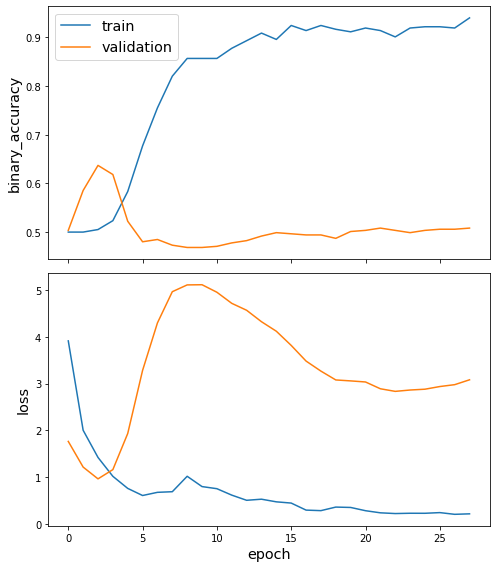

In [ ]:
sg.utils.plot_history(best_model_history)

In [ ]:
best_test_acc_for_fold

0.6370023488998413

In [ ]:
best_model_test_acc

0.6370023488998413

In [ ]:
test_accs

[0.6370023488998413,
 0.5292739868164062,
 0.5152224898338318,
 0.5058547854423523,
 0.466042160987854,
 0.466042160987854,
 0.40281030535697937,
 0.4530516564846039,
 0.4647887349128723,
 0.47652581334114075]

In [ ]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

In [ ]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G_adj)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=False, seed=42)

** Sampled 213 positive and 213 negative edges. **


In [ ]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, seed=42
)

** Sampled 192 positive and 192 negative edges. **


In [ ]:
epochs = 50
folds = 10

In [ ]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [ ]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

In [ ]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [ ]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [ ]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

In [ ]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 87ms/step - loss: 3.1643 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 3.1605
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 3.1643
	binary_accuracy: 0.5000


In [ ]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 1s - loss: 3.9775 - binary_accuracy: 0.5000 - val_loss: 2.2342 - val_binary_accuracy: 0.5000 - 1s/epoch - 1s/step
Epoch 2/50
1/1 - 0s - loss: 2.0835 - binary_accuracy: 0.5000 - val_loss: 1.6789 - val_binary_accuracy: 0.5070 - 113ms/epoch - 113ms/step
Epoch 3/50
1/1 - 0s - loss: 1.4761 - binary_accuracy: 0.5000 - val_loss: 1.3410 - val_binary_accuracy: 0.5235 - 110ms/epoch - 110ms/step
Epoch 4/50
1/1 - 0s - loss: 1.0641 - binary_accuracy: 0.5286 - val_loss: 1.0830 - val_binary_accuracy: 0.5399 - 120ms/epoch - 120ms/step
Epoch 5/50
1/1 - 0s - loss: 0.7906 - binary_accuracy: 0.5495 - val_loss: 0.9379 - val_binary_accuracy: 0.5822 - 112ms/epoch - 112ms/step
Epoch 6/50
1/1 - 0s - loss: 0.6122 - binary_accuracy: 0.6589 - val_loss: 0.9351 - val_binary_accuracy: 0.6009 - 109ms/epoch - 109ms/step
Epoch 7/50
1/1 - 0s - loss: 0.5727 - binary_accuracy: 0.7344 - val_loss: 1.1603 - val_binary_accuracy: 0.5939 - 105ms/epoch - 105ms/step
Epoch 8/50
1/1 - 0s - loss: 0.6314 - binary_acc

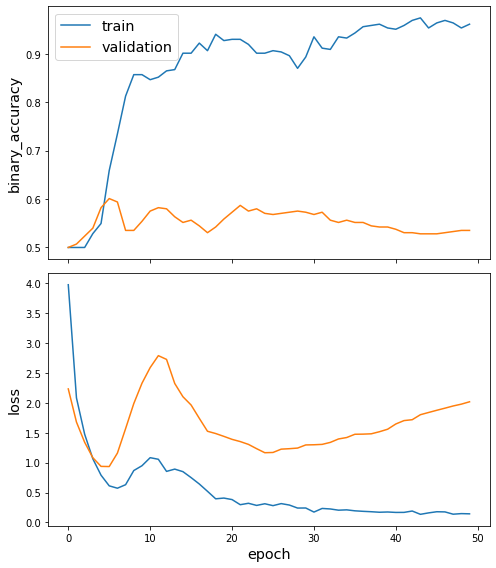

In [ ]:
sg.utils.plot_history(history)

In [ ]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 74ms/step - loss: 2.0188 - binary_accuracy: 0.5352

Train Set Metrics of the trained model:
	loss: 0.0945
	binary_accuracy: 0.9896

Test Set Metrics of the trained model:
	loss: 2.0188
	binary_accuracy: 0.5352


In [ ]:
list(G_adj.to_networkx().edges(data=True))[0]


In [ ]:
list(G_adj.to_networkx().nodes(data=True))[0]

## GCN seeds G_adj

In [ ]:
seeds = [i for i in range(10)]
seeds

In [ ]:
hist, models, trains_flow, tests_flow = gcn_seeds(G_adj, seeds)

In [ ]:
plot_history_all_seeds(hist)

In [ ]:
train_loss, train_acc, test_loss, test_acc = df_metrics_per_seed(models, trains_flow, tests_flow, seeds)

In [ ]:
df = df_seeds(seeds, train_loss, train_acc, test_loss, test_acc)
df

In [ ]:
df.mean()

In [ ]:
plot_metrics_all_seeds(df, seeds)

## GCN seeds G_adj only is_req

In [ ]:
g_adj = G_adj.to_networkx()

In [ ]:
list(g_adj.nodes(data=True))[0]

In [ ]:
list(g_adj.edges(data=True))[0]

In [ ]:
dic_adj = {}
for index, row in tqdm(df_adj_matrix.iterrows(),total=len(df_adj_matrix)): 
  dic_adj[index] = row.to_list()

In [ ]:
len(dic_adj)

In [ ]:
selected_edges_adj = [(u,v,e['label']) for u,v,e in g_adj.copy().edges(data=True) if e['label'] == 'is_requirement']

In [ ]:
selected_edges_adj

In [ ]:
g_adj_isreq = nx.edge_subgraph(g_adj, selected_edges_adj).copy()

In [ ]:
nx.set_node_attributes(g_adj_isreq, dic_adj, 'adj')

In [ ]:
G_adj_isreq = sg.StellarGraph.from_networkx(g_adj_isreq, node_features='adj', edge_type_attr='label')

In [ ]:
# hist, models, trains_flow, tests_flow = gcn_seeds(G_adj_isreq, seeds)

In [ ]:
# plot_history_all_seeds(hist)

In [ ]:
# train_loss, train_acc, test_loss, test_acc = df_metrics_per_seed(models, trains_flow, tests_flow, seeds)

In [ ]:
# df = df_seeds(seeds, train_loss, train_acc, test_loss, test_acc)
# df

In [ ]:
# df.mean()

In [ ]:
# plot_metrics_all_seeds(df, seeds)

# Exemplo da Proposta: embutir features de um modelo de linguagem

## KG

### Functions and libraries

In [ ]:
!pip install -q sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

### Model.encode

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [ ]:
feature_list = []
g_attr = KG.copy()
dic_embeddings = {}

for node_id, node_feature in tqdm(g_attr.nodes(data=True)):
  feature_linguagem =  model.encode(node_id)
  feature_list.append(feature_linguagem)
  node_feature['embeddings'] = feature_linguagem
  dic_embeddings[node_id] = feature_linguagem
  # print(node_id)
  # print(feature_linguagem)

In [ ]:
list(g_attr.nodes(data=True))[0]

In [ ]:
dic_embeddings

#### Exemplo de model.encode


In [ ]:
# # model.encode function example
# embeddings = model.encode(text[:10])

# #Print the embeddings
# for sentence, embedding in zip(text[:10], embeddings):
#     print("Sentence:", sentence)
#     print("Embedding:", embedding)
#     print("")

In [ ]:
# print(len(embeddings))

In [ ]:
# feature_linguagem

In [ ]:
# len(feature_linguagem)

### Creation of StellarGraph


In [ ]:
print(len(dic_embeddings))
print(len(dic_app_id))
print(len(KG.nodes))

In [ ]:
data = {'app_id': dic_app_id.values(), 'embeddings': dic_embeddings.values()}

features = pd.DataFrame(data, index=KG.nodes)
features

In [ ]:
G_emb = sg.StellarGraph.from_networkx(g_attr, node_features='embeddings', edge_type_attr="relation")

In [ ]:
list(G_emb.node_features())[0]

In [ ]:
print(G_emb.info())

In [ ]:
for i, j in zip(G_emb.nodes(), G_emb.node_features()):
  print(i, j)

In [ ]:
G_emb.to_networkx().edges(data=True)

## GCN implementation

In [ ]:
# Define an edge splitter on the or iginal graph G:
edge_splitter_test = EdgeSplitter(G_emb) # class

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True, seed=42)

- Negative edges = non-existent edges
- Positive edges = existing edges


**Sampling negatives:** \\
Two nodes are randomly selected at first. If they're not connected, the pair is considered negative. If connected, the process repeats.

**Sampling positives:** \\
Positive edges are sampled and then removed from the graph.
- keep_connected=True: the reduced graph remain connected. At first, the minimum spanning tree (MST) is calculated, they can't be sampled or removed. Other edges are then sampled at random.
- keep_connected=False: the reduced graph doesn't remain connected. Positive edges are sampled at random from full graph. MST isn't calculated.

OBS: \\
Minimum spanning tree (MST): it's undirected subgraph that connects all nodes with minimum total edge weight possible.

In [ ]:
len(G_test.nodes())

In [ ]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, seed=42
)

In [ ]:
G_train.number_of_nodes()

In [ ]:
epochs = 50

- Epoch: number of epochs means how many times you go through the entire training set. == number of iterations (if batch size is the entire training set)

- Batch size: n of samples processed before updating the model. It's a subset that goes through the model.

batches por epoch = training set / batch size

In [ ]:
edge_labels_train

In [ ]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")  # class
train_flow = train_gen.flow(edge_ids_train, edge_labels_train) # pair of nodes, labels (1=true link or 0=false link)

In [ ]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

In [ ]:
len(edge_ids_test)

In [ ]:
len(edge_labels_test)

In [ ]:
edge_ids_test

In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)



- the layer_sizes is a list of hidden feature sizes of each layer in the model. In this example we use two GCN layers with 16-dimensional hidden node features at each layer.
- activations is a list of activations applied to each layer’s output
- dropout=0.3 specifies a 30% dropout at each layer.


In [ ]:
x_inp, x_out = gcn.in_out_tensors()

In [ ]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [ ]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [ ]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

In [ ]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

In [ ]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

In [ ]:
sg.utils.plot_history(history) #sigmoid

In [ ]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

## GCN per seeds G with embeddings

In [ ]:
hist, models, trains_flow, tests_flow = gcn_seeds(G_emb, seeds)

In [ ]:
plot_history_all_seeds(hist)

In [ ]:
train_loss, train_acc, test_loss, test_acc = df_metrics_per_seed(models, trains_flow, tests_flow)

In [ ]:
df = df_seeds(seeds, train_loss, train_acc, test_loss, test_acc)
df

In [ ]:
df.mean()

In [ ]:
plot_metrics_all_seeds(df, seeds)

## GCN with only "is_requirement" feature

In [ ]:
def filter_by_isreq(g_attr, relation='relation', node_attr=dic_embeddings, node_attr_name='embeddings'):
  '''
  Returns stellargraph
  Parameters:
  ----------
  g_attr : networkx
  relation : str (ex: 'label')
  node_attr : dict (ex: dic_embeddings)
  node_attr_name : str (ex: embeddings)
  '''
  selected_edges = [(u,v) for u,v,e in g_attr.copy().edges(data=True) if e[relation] == 'is_requirement']
  g_attr_isreq = nx.edge_subgraph(g_attr, selected_edges).copy()
  nx.set_node_attributes(g_attr_isreq, node_attr, node_attr_name)

  H = sg.StellarGraph.from_networkx(g_attr_isreq, node_features=node_attr_name, edge_type_attr=relation)

  return H

In [ ]:
G_emb_isreq = filter_by_isreq(g_attr)
print(G_emb_isreq.info())

In [ ]:
hist, models, trains_flow, tests_flow = gcn_seeds(G_emb_isreq, seeds, test_keep_connected=False)

In [ ]:
plot_history_all_seeds(hist)

In [ ]:
train_loss, train_acc, test_loss, test_acc = df_metrics_per_seed(models, trains_flow, tests_flow)

In [ ]:
df = df_seeds(seeds, train_loss, train_acc, test_loss, test_acc)
df

In [ ]:
df.mean()

In [ ]:
plot_metrics_all_seeds(df, seeds)

# Select by appid

In [ ]:
def filter_nodes_by_appid(appid):
  '''
  appid : str
  '''
  selected_nodes = [k for k,v_list in dic_app_id.items() if appid in v_list]
  g_attr_appi = g_attr.subgraph(selected_nodes).copy()

  H = sg.StellarGraph.from_networkx(g_attr_appi, node_features='embeddings', edge_type_attr='relation')

  return H

In [ ]:
appid_list = ground_truth['App id'].unique()
appid_list

In [ ]:
appid = "com.zentertain.photoeditor"

Photoeditor = filter_nodes_by_appid(appid)
print(Photoeditor.info())

In [ ]:
hist, models, trains_flow, tests_flow = gcn_seeds(Photoeditor, seeds, test_keep_connected=True)

In [ ]:
plot_history_all_seeds(hist)

In [ ]:
train_loss, train_acc, test_loss, test_acc = df_metrics_per_seed(models, trains_flow, tests_flow)

In [ ]:
df = df_seeds(seeds, train_loss, train_acc, test_loss, test_acc)
df

In [ ]:
df.mean()

In [ ]:
plot_metrics_all_seeds(df, seeds)

# Giant Connected Component

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [ ]:
feature_list = []
g_gcc = subgraph_.copy()

for node_id, node_feature in tqdm(g_gcc.nodes(data=True)):
  feature_linguagem =  model.encode(node_id)
  feature_list.append(feature_linguagem)
  node_feature['embeddings'] = feature_linguagem
  # print(node_id)
  # print(feature_linguagem)

In [ ]:
g_gcc.nodes(data=True)

In [ ]:
g_gcc.edges(data=True)

In [ ]:
G_gcc = sg.StellarGraph.from_networkx(g_gcc, node_features="embeddings", edge_type_attr='relation')
print(G_gcc.info())

In [ ]:
print('Number of nodes: ', G_gcc.number_of_nodes())
print('Number of edges: ', G_gcc.number_of_edges())

## GCN seed único G_sub

In [ ]:
# # Define an edge splitter on the original graph G:
# edge_splitter_test = EdgeSplitter(G_sub)

# # Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# # reduced graph G_test with the sampled links removed:
# G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
#     p=0.1, method="global", keep_connected=True, seed=42)

In [ ]:
# # Define an edge splitter on the reduced graph G_test:
# edge_splitter_train = EdgeSplitter(G_test)

# # Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# # reduced graph G_train with the sampled links removed:
# G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
#     p=0.1, method="global", keep_connected=False, seed=42
# )

In [ ]:
# epochs = 50

In [ ]:
# train_gen = FullBatchLinkGenerator(G_train, method="gcn")
# train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

In [ ]:
# test_gen = FullBatchLinkGenerator(G_test, method="gcn")
# test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

In [ ]:
# gcn = GCN(
#     layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
# )

In [ ]:
# x_inp, x_out = gcn.in_out_tensors()

In [ ]:
# prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [ ]:
# prediction = keras.layers.Reshape((-1,))(prediction)

In [ ]:
# model = keras.Model(inputs=x_inp, outputs=prediction)

# model.compile(
#     optimizer=keras.optimizers.Adam(lr=0.01),
#     loss=keras.losses.binary_crossentropy,
#     metrics=["binary_accuracy"],
# )

In [ ]:
# init_train_metrics = model.evaluate(train_flow)
# init_test_metrics = model.evaluate(test_flow)

# print("\nTrain Set Metrics of the initial (untrained) model:")
# for name, val in zip(model.metrics_names, init_train_metrics):
#     print("\t{}: {:0.4f}".format(name, val))

# print("\nTest Set Metrics of the initial (untrained) model:")
# for name, val in zip(model.metrics_names, init_test_metrics):
#     print("\t{}: {:0.4f}".format(name, val))

In [ ]:
# history = model.fit(
#     train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
# )

## GCN 10 seeds G_sub

In [ ]:
seeds = [0,1,2,3,4,5,6,7,8,9]

# Giant Connected Component "is_requirement"

In [ ]:
G_gcc_isreq = filter_by_isreq(g_gcc)

print(G_gcc_isreq.info())

In [ ]:
hist_gcc, models_gcc, trains_flow_gcc, tests_flow_gcc = gcn_seeds(G_gcc_isreq, seeds, test_keep_connected=False)

In [ ]:
plot_history_all_seeds(hist_gcc)

In [ ]:
train_loss_gcc, train_acc_gcc, test_loss_gcc, test_acc_gcc = df_metrics_per_seed(models_gcc, trains_flow_gcc, tests_flow_gcc)

In [ ]:
df_gcc = df_seeds(seeds, train_loss_gcc, train_acc_gcc, test_loss_gcc, test_acc_gcc)
df_gcc

In [ ]:
df_gcc.mean()

In [ ]:
plot_metrics_all_seeds(df_gcc, seeds)